# PBL最終課題解答例

In [1]:
from sklearn.metrics import classification_report
from lifelines import CoxPHFitter
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

研究モデルの方針としては原因から結果へ向かう前向き研究を行う。そのためエビデンスレベルは比較的高め。
- horTh：ホルモン療法(Yes or No)
- age：患者の年齢
- menostat：閉経状態(pre：閉経前、post：閉経後)
- tsize：腫瘍サイズ(mm単位)
- tgrade：腫瘍のグレードⅠ<Ⅱ<Ⅲ
- pnodes：正のノードの数
- progrec:プロゲステロン受容体(fmol単位)
- stree：エストロゲン受容体(fmol単位)
- time：無再発生存期間(日数)
- cens：打ち切りインジケーター(0：打ち切り、1：イベント)

そのため時間的関係としては

ホルモン治療→共変量→腫瘍サイズ=腫瘍グレード→打ち切り

本データを扱うときのポイント
- 前向き研究を意識した分析ができているか
- 適切にデータの解釈ができているか
- 因果推論をできているか(相関と因果を勘違いしていないか)
- 仮説検証をしているか
- ダミー変数の扱い方を理解しているか
- 回帰と判別を正しくモデル構築できているか
- 回帰の結果からデータの選定が間違っていることに気付けるか
- 判別モデルを独自に作成した時にロジスティック回帰を超えられるか

## データの読み込み

In [2]:
df = pd.read_csv("gbsg2.csv")
df.head()

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


In [3]:
df.describe()

,age,tsize,pnodes,progrec,estrec,time,cens
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,53.052478,29.329446,5.010204,109.995627,96.252187,1124.489796,0.435860
std,10.120739,14.296217,5.475483,202.331552,153.083963,642.791948,0.496231
min,21.000000,3.000000,1.000000,0.000000,0.000000,8.000000,0.000000
25%,46.000000,20.000000,1.000000,7.000000,8.000000,567.750000,0.000000
50%,53.000000,25.000000,3.000000,32.500000,36.000000,1084.000000,0.000000
75%,61.000000,35.000000,7.000000,131.750000,114.000000,1684.750000,1.000000
max,80.000000,120.000000,51.000000,2380.000000,1144.000000,2659.000000,1.000000


## データの把握
### 相関行列の作成

In [4]:
df.corr()

C:\Users\decar\AppData\Local\Temp\ipykernel_20412\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,age,tsize,pnodes,progrec,estrec,time,cens
age,1.000000,-0.045412,0.032709,0.084355,0.323132,0.053958,-0.004270
tsize,-0.045412,1.000000,0.327665,-0.027415,-0.081766,-0.138376,0.130978
pnodes,0.032709,0.327665,1.000000,-0.072534,-0.043183,-0.256751,0.242287
progrec,0.084355,-0.027415,-0.072534,1.000000,0.392601,0.102729,-0.171596
estrec,0.323132,-0.081766,-0.043183,0.392601,1.000000,0.065477,-0.061561
time,0.053958,-0.138376,-0.256751,0.102729,0.065477,1.000000,-0.447103
cens,-0.004270,0.130978,0.242287,-0.171596,-0.061561,-0.447103,1.000000


### ペアプロット
ペアプロットを使用することで結果系変数ごとの分布と散布図を確認できる

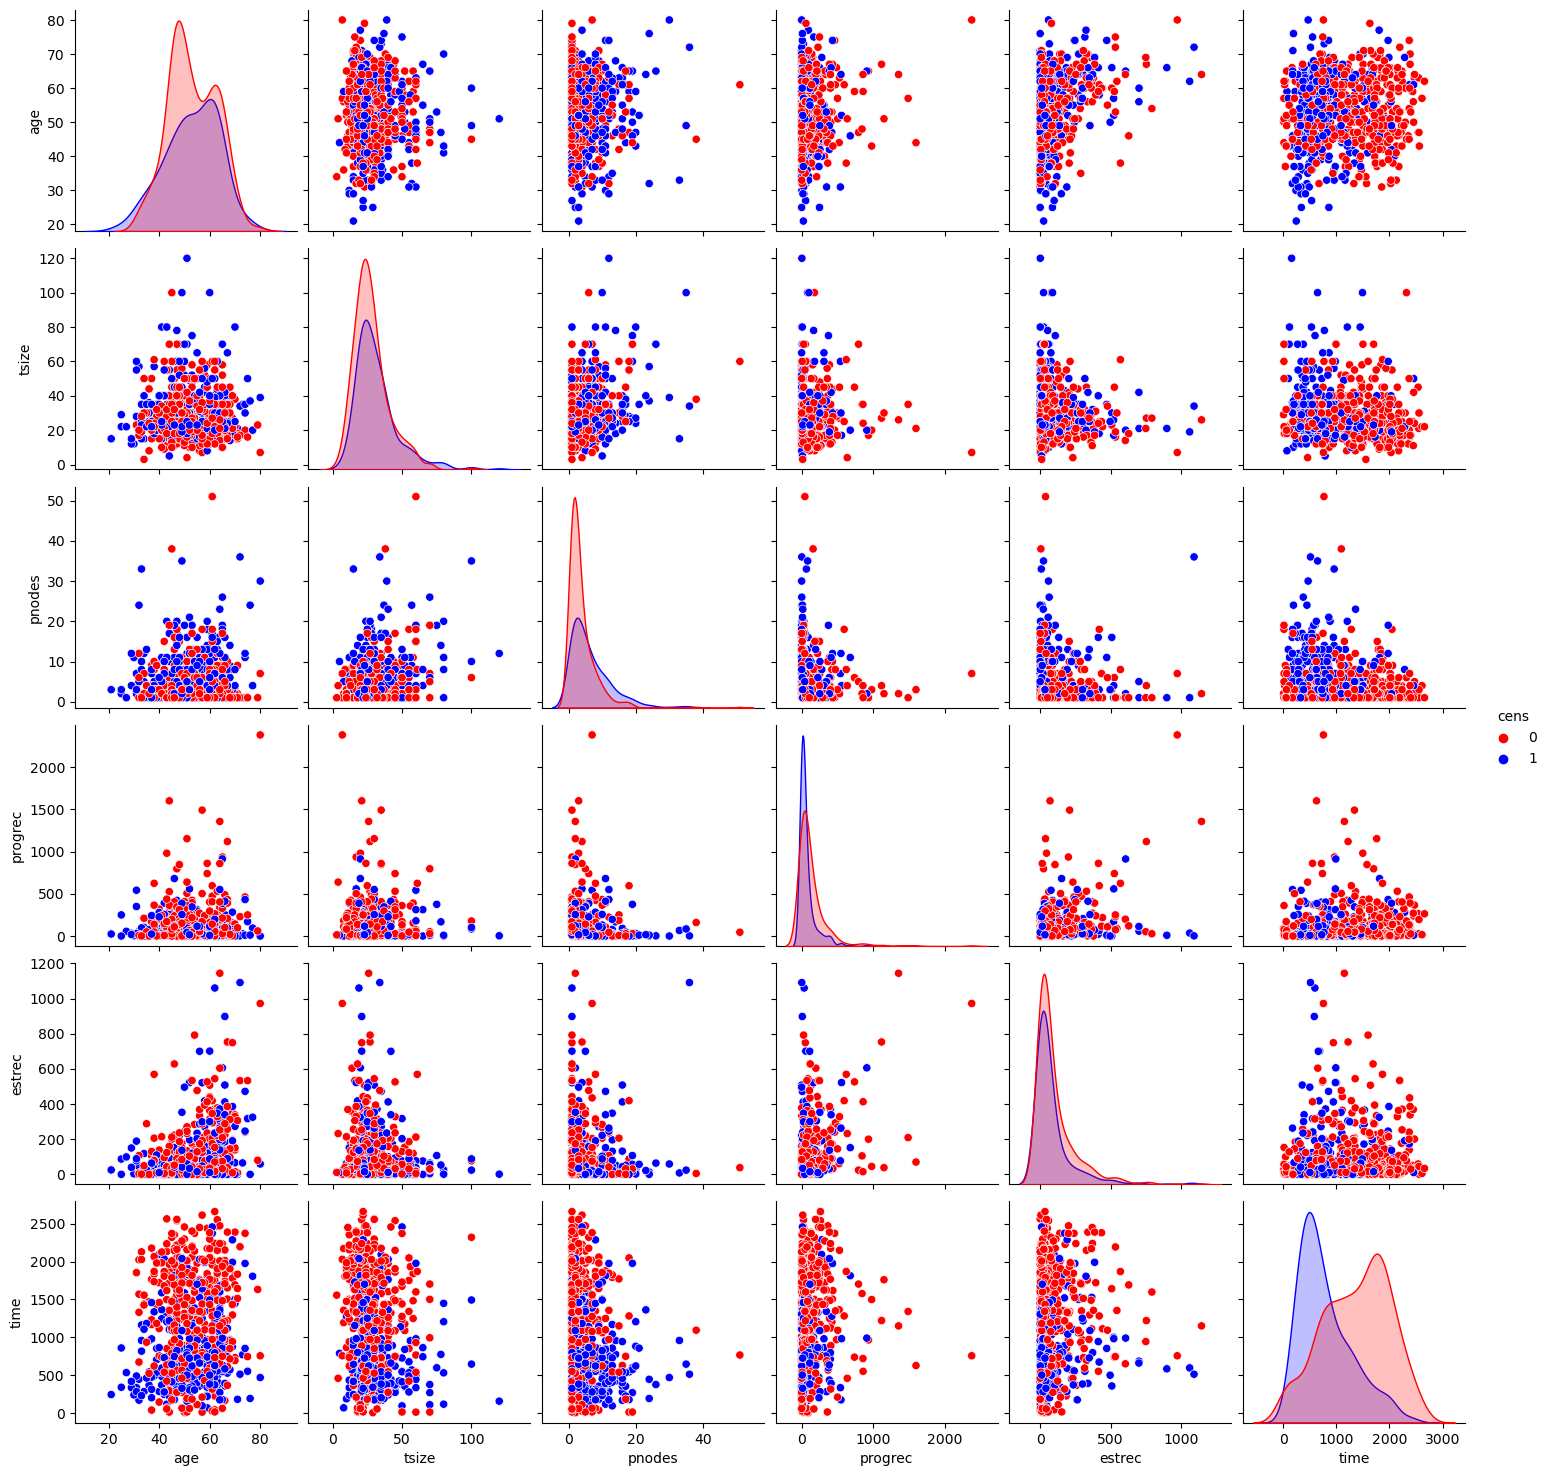

In [5]:
sns.pairplot(df, hue="cens", diag_kind="kde", palette={0: "#FF0000", 1: "#0000FF"})

### カーネル密度関数
ペアプロットにおける対角要素であるデータの分布を取り出す

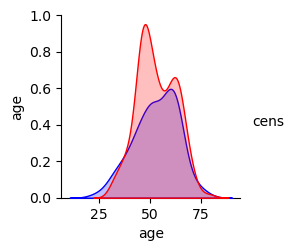

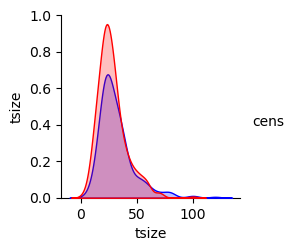

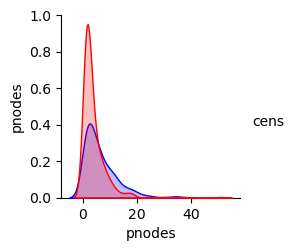

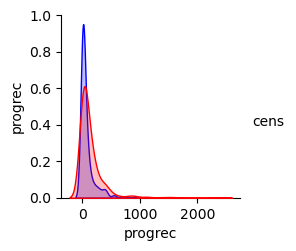

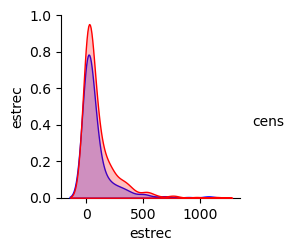

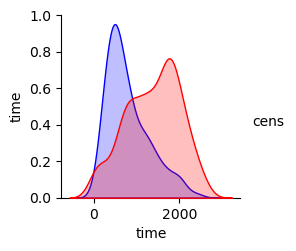

In [6]:
columns = ["age", "tsize", "pnodes", "progrec", "estrec", "time"]
for col in columns:
    if col != "cens":
        sns.pairplot(df, hue="cens", x_vars=[col], y_vars=[col], palette={0: "#FF0000", 1: "#0000FF"})

### 因果推論と仮説検証
結果を腫瘍のサイズとする。

In [7]:
columns = ["horTh", "menostat", "tgrade", "cens"]
vals = []
name1 = []
cnt = []
count = 0
for col in columns:
    tmp = []
    name = []
    tmpc = []
    value = list(set(df[col].values))
    for val in value:
        if col != "cens":
            df_q = df.query("%s=='%s'"%(col, val))
        else:
            df_q = df.query("%s==%s"%(col, val))
        tmp.append(df_q["tsize"].values.tolist())
        name.append(col+"_"+str(val))
        tmpc.append(count)
        count = count + 1
    vals.append(tmp)
    name1.append(name)
    cnt.append(tmpc)

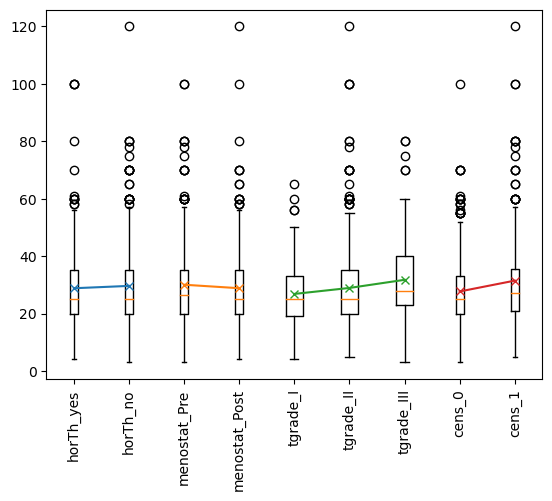

,カラム名,値,平均値,標準偏差,サンプル数
0,horTh,yes,28.80,14.091835,246
1,horTh,no,29.62,14.384759,440
2,menostat,Pre,30.03,15.325741,290
3,menostat,Post,28.82,13.450202,396
4,tgrade,I,26.83,12.060332,81
5,tgrade,II,28.91,14.674054,444
6,tgrade,III,31.74,13.897371,161
7,cens,0,27.68,12.825356,387
8,cens,1,31.46,15.725725,299


In [8]:
NC = []
for i in range(len(vals)):
    plt.boxplot(vals[i], positions=cnt[i], labels=name1[i])
    ave = []
    for j in range(len(vals[i])):
        ave.append(sum(vals[i][j])/len(vals[i][j]))
        NC.append([name1[i][j].split("_")[0], 
                   name1[i][j].split("_")[1], 
                   "%.2f"%(sum(vals[i][j])/len(vals[i][j])),
                   np.std(vals[i][j]),
                   len(vals[i][j])
                  ])
    plt.plot(cnt[i], ave, marker="x")
plt.xticks(rotation=90)
plt.show()
df_NC = pd.DataFrame(NC)
df_NC.columns = ["カラム名", "値", "平均値", "標準偏差", "サンプル数"]
df_NC

In [9]:
horTh_no = df.query("horTh=='no'")["tsize"].values
horTh_yes = df.query("horTh=='yes'")["tsize"].values

In [10]:
menostat_Pre = df.query("menostat=='Pre'")["tsize"].values
menostat_Post = df.query("menostat=='Post'")["tsize"].values

In [11]:
tgrade_3 = df.query("tgrade=='III'")["tsize"].values
tgrade_2 = df.query("tgrade=='II'")["tsize"].values
tgrade_1 = df.query("tgrade=='I'")["tsize"].values

In [12]:
cens_0 = df.query("cens==0")["tsize"].values
cens_1 = df.query("cens==1")["tsize"].values

#### ナイーブな比較
各変数を腫瘍のサイズに対してどの程度効果があるか検証するために介入および状況の効果測定を行う

In [13]:
print("horTh:      Yes-No  = "+str(np.mean(horTh_yes)-np.mean(horTh_no)))
print("menostat:   Pre-Post= "+str(np.mean(menostat_Pre)-np.mean(menostat_Post)))
print("tgrade:     III-I   = "+str(np.mean(tgrade_3)-np.mean(tgrade_1)))
print("tgrade:     II-Ⅰ   = "+str(np.mean(tgrade_2)-np.mean(tgrade_1)))
print("tgrade:     III-II  = "+str(np.mean(tgrade_3)-np.mean(tgrade_2)))
print("cens:       1-0     = "+str(np.mean(cens_1)-np.mean(cens_0)))

horTh:      Yes-No  = -0.8178492239467836
menostat:   Pre-Post= 1.2153779171020567
tgrade:     III-I   = 4.911969940955448
tgrade:     II-Ⅰ   = 2.085001668335
tgrade:     III-II  = 2.826968272620448
cens:       1-0     = 3.7734394579692854


#### 有意差の検証
ナイーブな比較をした時の値が有意かどうか検証する。例えば、ナイーブな比較をした時に値が大きくても有意ではない場合もあるため確実な因果関係を考察するために検証する。

In [14]:
print("horTh:      Yes,No   pValue = "+str(stats.ttest_ind(horTh_yes, horTh_no)[1]))
print("menostat:   Pre,Post pValue = "+str(stats.ttest_ind(menostat_Pre, menostat_Post)[1]))
print("tgrade:     III,I    pValue = "+str(stats.ttest_ind(tgrade_3, tgrade_1)[1]))
print("tgrade:     II,Ⅰ    pValue = "+str(stats.ttest_ind(tgrade_2, tgrade_1)[1]))
print("tgrade:     III,II   pValue = "+str(stats.ttest_ind(tgrade_3, tgrade_2)[1]))
print("cens:       1,0      pValue = "+str(stats.ttest_ind(cens_1, cens_0)[1]))

horTh:      Yes,No   pValue = 0.4727925350646627
menostat:   Pre,Post pValue = 0.2716653926829643
tgrade:     III,I    pValue = 0.007476739582096858
tgrade:     II,Ⅰ    pValue = 0.22901758100491845
tgrade:     III,II   pValue = 0.03442165766785967
cens:       1,0      pValue = 0.0005836378307877615


### リスク比の算出とカイ二乗検定
原因であるホルモン注射による介入や閉経状態が腫瘍のサイズに与えている影響について解析する。
#### ホルモン注射と腫瘍の度合い

In [15]:
columns = ["horTh", "menostat", "tgrade"]
df_risk_h2t = pd.crosstab(df["horTh"], df["cens"])
df_risk_h2t

cens,0,1
horTh,,
no,235,205
yes,152,94


In [16]:
cross = df_risk_h2t.values
risk = []
risk.append(cross[0][1]/sum(cross[0]))
risk.append(cross[1][1]/sum(cross[1]))
risk_rate = []
risk_rate.append(risk[0]/risk[1])
df_crs = pd.DataFrame(risk)
df_crs = pd.concat([df_crs, pd.DataFrame(risk_rate)], axis=1)
df_crs.index = df_risk_h2t.index
df_crs.columns = ["risk", "risk_rate"]
df_crs

,risk,risk_rate
horTh,,
no,0.465909,1.219294
yes,0.382114,NaN


In [17]:
x2, p, dfv, expected = stats.chi2_contingency(df_risk_h2t)
print("p-value = ", p)
df_expected = pd.DataFrame(expected)
df_expected.columns = df_risk_h2t.columns
df_expected.index = df_risk_h2t.index
df_expected

p-value =  0.04111128080188675


cens,0,1
horTh,,
no,248.221574,191.778426
yes,138.778426,107.221574


#### 閉経かどうかと腫瘍の度合い

In [18]:
df_risk_m2t = pd.crosstab(df["menostat"], df["cens"])
df_risk_m2t

cens,0,1
menostat,,
Post,216,180
Pre,171,119


In [19]:
cross = df_risk_m2t.values
risk = []
risk.append(cross[0][1]/sum(cross[0]))
risk.append(cross[1][1]/sum(cross[1]))
risk_rate = []
risk_rate.append(risk[0]/risk[1])
df_crs = pd.DataFrame(risk)
df_crs = pd.concat([df_crs, pd.DataFrame(risk_rate)], axis=1)
df_crs.index = df_risk_h2t.index
df_crs.columns = ["risk", "risk_rate"]
df_crs

,risk,risk_rate
horTh,,
no,0.454545,1.107716
yes,0.410345,NaN


In [20]:
x2, p, dfv, expected = stats.chi2_contingency(df_risk_m2t)
print("p-value = ", p)
df_expected = pd.DataFrame(expected)
df_expected.columns = df_risk_m2t.columns
df_expected.index = df_risk_m2t.index
df_expected

p-value =  0.2822058085385014


cens,0,1
menostat,,
Post,223.399417,172.600583
Pre,163.600583,126.399417


In [21]:
df_risk_hm2t = pd.crosstab([df["horTh"], df["menostat"]], df["cens"])
df_risk_hm2t

cens              0    1
horTh menostat          
no    Post      101  108
      Pre       134   97
yes   Post      115   72
      Pre        37   22

In [22]:
cross = df_risk_hm2t.values
risk = []
risk.append(cross[0][1]/sum(cross[0]))
risk.append(cross[1][1]/sum(cross[1]))
risk.append(cross[2][1]/sum(cross[2]))
risk.append(cross[3][1]/sum(cross[3]))
risk_rate = []
risk_rate.append(risk[0]/risk[2])
risk_rate.append(risk[1]/risk[3])
risk_rate2 = [risk_rate[0]/risk_rate[1]]
df_crs = pd.DataFrame(risk)
df_crs = pd.concat([df_crs, pd.DataFrame(risk_rate), pd.DataFrame(risk_rate2)], axis=1)
df_crs.columns = ["risk", "risk_rate", "risk_rate(all)"]
df_crs.index = df_risk_hm2t.index
df_crs

risk  risk_rate  risk_rate(all)
horTh menostat                                     
no    Post      0.516746   1.342105        1.191784
      Pre       0.419913   1.126131             NaN
yes   Post      0.385027        NaN             NaN
      Pre       0.372881        NaN             NaN

In [23]:
x2, p, dfv, expected = stats.chi2_contingency(df_risk_hm2t)
print("p-value = ", p)
df_expected = pd.DataFrame(expected)
df_expected.columns = df_risk_hm2t.columns
df_expected.index = df_risk_hm2t.index
df_expected

p-value =  0.033301100108598734


cens                     0           1
horTh menostat                        
no    Post      117.905248   91.094752
      Pre       130.316327  100.683673
yes   Post      105.494169   81.505831
      Pre        33.284257   25.715743

これらの結果からホルモン注射と腫瘍の大きさが一番理論値と実測値が異なることが分かる。

ここで、horthは原因となり、censが結果となってその他は交絡因子になる。

## 数理モデルの作成
### ダミー変数の作成

In [24]:
df_dum = pd.get_dummies(df)
df_dum.head()

,age,tsize,pnodes,progrec,estrec,time,cens,horTh_no,horTh_yes,menostat_Post,menostat_Pre,tgrade_I,tgrade_II,tgrade_III
0,70,21,3,48,66,1814,1,1,0,1,0,0,1,0
1,56,12,7,61,77,2018,1,0,1,1,0,0,1,0
2,58,35,9,52,271,712,1,0,1,1,0,0,1,0
3,59,17,4,60,29,1807,1,0,1,1,0,0,1,0
4,73,35,1,26,65,772,1,1,0,1,0,0,1,0


In [25]:
df_dum.describe()

,age,tsize,pnodes,progrec,estrec,time,cens,horTh_no,horTh_yes,menostat_Post,menostat_Pre,tgrade_I,tgrade_II,tgrade_III
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.00000,686.000000
mean,53.052478,29.329446,5.010204,109.995627,96.252187,1124.489796,0.435860,0.641399,0.358601,0.577259,0.422741,0.118076,0.64723,0.234694
std,10.120739,14.296217,5.475483,202.331552,153.083963,642.791948,0.496231,0.479940,0.479940,0.494355,0.494355,0.322933,0.47818,0.424117
min,21.000000,3.000000,1.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,46.000000,20.000000,1.000000,7.000000,8.000000,567.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,53.000000,25.000000,3.000000,32.500000,36.000000,1084.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000
75%,61.000000,35.000000,7.000000,131.750000,114.000000,1684.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000,0.000000
max,80.000000,120.000000,51.000000,2380.000000,1144.000000,2659.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [26]:
df_dum.corr()

,age,tsize,pnodes,progrec,estrec,time,cens,horTh_no,horTh_yes,menostat_Post,menostat_Pre,tgrade_I,tgrade_II,tgrade_III
age,1.000000,-0.045412,0.032709,0.084355,0.323132,0.053958,-0.004270,-0.263906,0.263906,0.770076,-0.770076,0.034281,0.041839,-0.073275
tsize,-0.045412,1.000000,0.327665,-0.027415,-0.081766,-0.138376,0.130978,0.027456,-0.027456,-0.042027,0.042027,-0.064091,-0.039565,0.093409
pnodes,0.032709,0.327665,1.000000,-0.072534,-0.043183,-0.256751,0.242287,-0.016382,0.016382,0.023169,-0.023169,-0.117093,-0.017580,0.108979
progrec,0.084355,-0.027415,-0.072534,1.000000,0.392601,0.102729,-0.171596,-0.052874,0.052874,0.018649,-0.018649,0.146084,0.023175,-0.137362
estrec,0.323132,-0.081766,-0.043183,0.392601,1.000000,0.065477,-0.061561,-0.144512,0.144512,0.258860,-0.258860,0.064895,0.058194,-0.115025
time,0.053958,-0.138376,-0.256751,0.102729,0.065477,1.000000,-0.447103,-0.134838,0.134838,0.024712,-0.024712,0.118089,0.049530,-0.145760
cens,-0.004270,0.130978,0.242287,-0.171596,-0.061561,-0.447103,1.000000,0.081044,-0.081044,0.044034,-0.044034,-0.157643,0.052160,0.061225
horTh_no,-0.263906,0.027456,-0.016382,-0.052874,-0.144512,-0.134838,0.081044,1.000000,-1.000000,-0.276847,0.276847,-0.037237,-0.024053,0.055473
horTh_yes,0.263906,-0.027456,0.016382,0.052874,0.144512,0.134838,-0.081044,-1.000000,1.000000,0.276847,-0.276847,0.037237,0.024053,-0.055473
menostat_Post,0.770076,-0.042027,0.023169,0.018649,0.258860,0.024712,0.044034,-0.276847,0.276847,1.000000,-1.000000,0.011357,0.029005,-0.041351


### VIFによる多重共線性の確認

In [27]:
inv = np.linalg.inv(df_dum.corr())
vif = []
for i in range(len(inv)):
    vif.append(inv[i][i])
df_vif = pd.DataFrame(vif)
df_vif.index = df_dum.corr().index
df_vif.columns = ["VIF"]
df_vif.sort_values("VIF", ascending=False)

,VIF
menostat_Post,1.923719e+15
menostat_Pre,1.923719e+15
age,2.590270e+00
estrec,1.329215e+00
cens,1.326031e+00
time,1.325326e+00
progrec,1.246844e+00
pnodes,1.218249e+00
tsize,1.136771e+00
tgrade_I,-9.642524e+14


この結果から閉経かどうかが多重共線性の要因になっている。

### 変数選択①
必要最低限しか変数を除去しない場合

In [28]:
df2 = df_dum.drop(["menostat_Pre", "tgrade_I", "horTh_no"], axis=1)
df2.head()

,age,tsize,pnodes,progrec,estrec,time,cens,horTh_yes,menostat_Post,tgrade_II,tgrade_III
0,70,21,3,48,66,1814,1,0,1,1,0
1,56,12,7,61,77,2018,1,1,1,1,0
2,58,35,9,52,271,712,1,1,1,1,0
3,59,17,4,60,29,1807,1,1,1,1,0
4,73,35,1,26,65,772,1,0,1,1,0


### 重回帰分析
回帰係数から目的変数の傾向が分かる。ここでは後に使用する変数選択したモデルとの比較のために使用する精度指標は「Adj. R-squared」とする。

In [29]:
x = sm.add_constant(df2.drop(["tsize", "cens"], axis=1))
y = df2["tsize"]

In [30]:
model1_1 = sm.OLS(y, x).fit()
model1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tsize   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     10.14
Date:                Wed, 12 Jul 2023   Prob (F-statistic):           9.98e-15
Time:                        10:26:32   Log-Likelihood:                -2754.2
No. Observations:                 686   AIC:                             5528.
Df Residuals:                     676   BIC:                             5574.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            27.6990      4.094      6.766      0.000      19.661      35.737
age              -0.0284      0.082     -0.346      0.729      -0.189       0.133
pnodes            0.8090      0.098      8.216      0.000       0.616       1.002
progrec           0.0025      0.003      0.868      0.386      -0.003       0.008
estrec           -0.0058      0.004     -1.490      0.137      -0.013       0.002
time             -0.0011      0.001     -1.253      0.211      -0.003       0.001
horTh_yes        -0.2089      1.136     -0.184      0.854      -2.439       2.022
menostat_Post    -0.3816      1.656     -0.230      0.818      -3.634       2.871
tgrade_II         0.5726      1.655      0.346      0.729      -2.677       3.822
tgrade_III        2.0991      1.906      1.101      0.271      -1.643       5.841
==============================================================================
Omnibus:                      226.839   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              880.213
Skew:                           1.506   Prob(JB):                    7.31e-192
Kurtosis:                       7.661   Cond. No.                     1.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ロジスティック回帰
回帰係数から結果を予測できる。また、モデルの妥当性は分類レポートを使用して詳細に見る。

In [31]:
x = sm.add_constant(df2.drop("cens", axis=1))
y = df2["cens"]

In [32]:
model2_1 = sm.Logit(y, x).fit()
model2_1.summary()

Optimization terminated successfully.
         Current function value: 0.546206
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cens   No. Observations:                  686
Model:                          Logit   Df Residuals:                      675
Method:                           MLE   Df Model:                           10
Date:                Wed, 12 Jul 2023   Pseudo R-squ.:                  0.2025
Time:                        10:26:32   Log-Likelihood:                -374.70
converged:                       True   LL-Null:                       -469.84
Covariance Type:            nonrobust   LLR p-value:                 1.707e-35
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8411      0.750      1.122      0.262      -0.628       2.311
age              -0.0122      0.014     -0.852      0.394      -0.040       0.016
tsize             0.0075      0.007      1.100      0.271      -0.006       0.021
pnodes            0.0562      0.020      2.867      0.004       0.018       0.095
progrec          -0.0018      0.001     -2.776      0.006      -0.003      -0.001
estrec            0.0003      0.001      0.466      0.641      -0.001       0.002
time             -0.0015      0.000     -9.393      0.000      -0.002      -0.001
horTh_yes        -0.2621      0.199     -1.315      0.189      -0.653       0.129
menostat_Post     0.5592      0.290      1.931      0.053      -0.008       1.127
tgrade_II         0.7444      0.316      2.359      0.018       0.126       1.363
tgrade_III        0.4403      0.355      1.240      0.215      -0.256       1.136
=================================================================================
"""

In [33]:
y_pred = model2_1.predict(x)

In [34]:
y_pred_bin = []
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred_bin.append(1)
    else:
        y_pred_bin.append(0)
print(classification_report(y, y_pred_bin))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       387
           1       0.69      0.68      0.68       299

    accuracy                           0.73       686
   macro avg       0.72      0.72      0.72       686
weighted avg       0.73      0.73      0.73       686



### Cox比例ハザード分析

In [35]:
model3_1 = CoxPHFitter()
model3_1.fit(df2,duration_col="time",event_col="cens")
model3_1.print_summary()

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1735.73
         time fit was run = 2023-07-12 01:26:32 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
age            -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
tsize           0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
pnodes          0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
progrec        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
estrec          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
horTh_yes      -0.35       0.71       0.13            -0.60            -0.09                 0.55                 0.91
menostat_Post   0.26       1.29       0.18            -0.10             0.62                 0.90                 1.86
tgrade_II       0.64       1.89       0.25             0.15             1.12                 1.16                 3.08
tgrade_III      0.78       2.18       0.27             0.25             1.31                 1.29                 3.69

                cmp to     z      p   -log2(p)
covariate                                     
age               0.00 -1.02   0.31       1.69
tsize             0.00  1.98   0.05       4.39
pnodes            0.00  6.55 <0.005      34.03
progrec           0.00 -3.87 <0.005      13.14
estrec            0.00  0.44   0.66       0.60
horTh_yes         0.00 -2.68   0.01       7.10
menostat_Post     0.00  1.41   0.16       2.65
tgrade_II         0.00  2.55   0.01       6.55
tgrade_III        0.00  2.90 <0.005       8.08
---
Concordance = 0.69
Partial AIC = 3489.46
log-likelihood ratio test = 104.75 on 9 df
-log2(p) of ll-ratio test = 59.01

### 変数選択②
VIFが10を超えていた「閉経かどうか」を消した場合

In [36]:
df3 = df_dum.drop(["menostat_Pre", 
                   "menostat_Post", 
                   "tgrade_I", 
                   "horTh_no", 
                   "tgrade_II", 
                   "tgrade_III",
                   "horTh_yes"], axis=1)
df3.head()

,age,tsize,pnodes,progrec,estrec,time,cens
0,70,21,3,48,66,1814,1
1,56,12,7,61,77,2018,1
2,58,35,9,52,271,712,1
3,59,17,4,60,29,1807,1
4,73,35,1,26,65,772,1


In [37]:
x = sm.add_constant(df3.drop(["tsize", "cens"], axis=1))
y = df3["tsize"]

In [38]:
model1_2 = sm.OLS(y, x).fit()
model1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tsize   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     17.94
Date:                Wed, 12 Jul 2023   Prob (F-statistic):           9.84e-17
Time:                        10:26:32   Log-Likelihood:                -2755.1
No. Observations:                 686   AIC:                             5522.
Df Residuals:                     680   BIC:                             5549.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.5052      2.985      9.884      0.000      23.644      35.366
age           -0.0483      0.054     -0.894      0.372      -0.154       0.058
pnodes         0.8200      0.098      8.397      0.000       0.628       1.012
progrec        0.0021      0.003      0.747      0.455      -0.003       0.008
estrec        -0.0061      0.004     -1.576      0.115      -0.014       0.001
time          -0.0012      0.001     -1.457      0.145      -0.003       0.000
==============================================================================
Omnibus:                      223.357   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              839.580
Skew:                           1.493   Prob(JB):                    4.87e-183
Kurtosis:                       7.523   Cond. No.                     7.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
x = sm.add_constant(df3.drop("cens", axis=1))
y = df3["cens"]

In [40]:
model2_2 = sm.Logit(y, x).fit()
model2_2.summary()

Optimization terminated successfully.
         Current function value: 0.554888
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cens   No. Observations:                  686
Model:                          Logit   Df Residuals:                      679
Method:                           MLE   Df Model:                            6
Date:                Wed, 12 Jul 2023   Pseudo R-squ.:                  0.1898
Time:                        10:26:32   Log-Likelihood:                -380.65
converged:                       True   LL-Null:                       -469.84
Covariance Type:            nonrobust   LLR p-value:                 7.525e-36
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7806      0.544      1.435      0.151      -0.285       1.847
age            0.0049      0.009      0.529      0.597      -0.013       0.023
tsize          0.0071      0.007      1.058      0.290      -0.006       0.020
pnodes         0.0573      0.020      2.933      0.003       0.019       0.096
progrec       -0.0020      0.001     -3.106      0.002      -0.003      -0.001
estrec         0.0004      0.001      0.613      0.540      -0.001       0.002
time          -0.0015      0.000     -9.577      0.000      -0.002      -0.001
==============================================================================
"""

In [41]:
y_pred = model2_2.predict(x)

In [42]:
y_pred_bin = []
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred_bin.append(1)
    else:
        y_pred_bin.append(0)
print(classification_report(y, y_pred_bin))

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       387
           1       0.68      0.67      0.67       299

    accuracy                           0.72       686
   macro avg       0.72      0.71      0.71       686
weighted avg       0.72      0.72      0.72       686



In [43]:
model3_2 = CoxPHFitter()
model3_2.fit(df2,duration_col="time",event_col="cens")
model3_2.print_summary()

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1735.73
         time fit was run = 2023-07-12 01:26:33 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
age            -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
tsize           0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
pnodes          0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
progrec        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
estrec          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
horTh_yes      -0.35       0.71       0.13            -0.60            -0.09                 0.55                 0.91
menostat_Post   0.26       1.29       0.18            -0.10             0.62                 0.90                 1.86
tgrade_II       0.64       1.89       0.25             0.15             1.12                 1.16                 3.08
tgrade_III      0.78       2.18       0.27             0.25             1.31                 1.29                 3.69

                cmp to     z      p   -log2(p)
covariate                                     
age               0.00 -1.02   0.31       1.69
tsize             0.00  1.98   0.05       4.39
pnodes            0.00  6.55 <0.005      34.03
progrec           0.00 -3.87 <0.005      13.14
estrec            0.00  0.44   0.66       0.60
horTh_yes         0.00 -2.68   0.01       7.10
menostat_Post     0.00  1.41   0.16       2.65
tgrade_II         0.00  2.55   0.01       6.55
tgrade_III        0.00  2.90 <0.005       8.08
---
Concordance = 0.69
Partial AIC = 3489.46
log-likelihood ratio test = 104.75 on 9 df
-log2(p) of ll-ratio test = 59.01

In [44]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score, accuracy_score
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [45]:
y = df2["tsize"]
x = df2.drop("tsize", axis=1)

In [46]:
models = []

In [47]:
for i in range(10):
    x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=i)
    model = GBR()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    models.append([model, r2_score(y_test, y_pred), x_train, y_train])

In [48]:
models = sorted(models, key=lambda x: x[1], reverse=True)

In [49]:
model = models[0][0]
r2 = models[0][1]
x_train = models[0][2]
y_train = models[0][3]
print("R2-Score = " + str(r2))

R2-Score = 0.17663645392092708


In [50]:
y = df2["cens"]
x = df2.drop("cens", axis=1)

In [51]:
models = []

In [52]:
for i in range(10):
    x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=i)
    model = GBC()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    models.append([model, accuracy_score(y_test, y_pred), x_train, y_train, classification_report(y_test, y_pred)])

In [53]:
models = sorted(models, key=lambda x: x[1], reverse=True)

In [54]:
model = models[0][0]
acc = models[0][1]
x_train = models[0][2]
y_train = models[0][3]
print(models[0][4])

              precision    recall  f1-score   support

           0       0.77      0.85      0.80        78
           1       0.77      0.67      0.71        60

    accuracy                           0.77       138
   macro avg       0.77      0.76      0.76       138
weighted avg       0.77      0.77      0.77       138



この結果からtsizeに関しては説明変数による説明力が極端に小さくtsizeのモデル化にはこのデータセットとは異なる変数を使う必要がある。

また、censは77%の正解率がある。